# Install packages

In [ ]:
# had to use pip since it wasn't available with mamba
%pip install duckduckgo_search

In [ ]:
%mamba install fastai

## Step 1: Download images of birds and non-birds

In [1]:
from duckduckgo_search import DDGS
from fastcore.all import *

def search_images(term, max_images=30):
    print(f"Searching for '{term}'")
    return L(DDGS().images(term, max_results=max_images)).itemgot('image')

Let's start by searching for an electric motorcylce photo and seeing what kind of result we get. We'll start by getting URLs from a search:

In [2]:
#NB: `search_images` depends on duckduckgo.com, which doesn't always return correct responses.
#    If you get a JSON error, just try running it again (it may take a couple of tries).
urls = search_images('electric motorcylce photos', max_images=1)
urls[0]

Searching for 'electric motorcylce photos'


'https://cdn.luxe.digital/media/2020/12/21114904/best-electric-motorcycles-2021-luxury-Damon-Hypersport-Pro-luxe-digital@2x.jpg'

...and then download a URL and take a look at it:

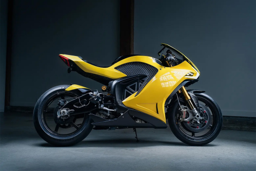

In [3]:
from fastdownload import download_url
from fastai.vision.all import Image
dest = 'electric_motorcycle.jpg'
download_url(urls[0], dest, show_progress=True)

im = Image.open(dest)
im.to_thumb(256,256)

Now let's do the same with "gas motorcycle photos":

Searching for 'gas motorcyle photos'


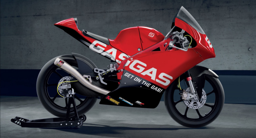

In [4]:
download_url(search_images('gas motorcyle photos', max_images=1)[0], 'gas_motorcycle.jpg', show_progress=True)
Image.open('gas_motorcycle.jpg').to_thumb(256,256)

Our searches seem to be giving reasonable results, so let's grab a few examples of each of "electric motorcylce" and "gas motorcylce" photos, and save each group of photos to a different folder (I'm also trying to grab a range of potential environments):

In [7]:
searches = 'electric motorcycle','gas motorcylce'
path = Path('electric_or_gas')
from time import sleep
from fastai.vision.all import download_images, resize_images

for o in searches:
    dest = (path/o)
    dest.mkdir(exist_ok=True, parents=True)
    download_images(dest, urls=search_images(f'{o} photo'))
    sleep(10)  # Pause between searches to avoid over-loading server
    download_images(dest, urls=search_images(f'{o} street photo'))
    sleep(10)
    download_images(dest, urls=search_images(f'{o} showroom photo'))
    sleep(10)
    resize_images(path/o, max_size=400, dest=path/o)

Searching for 'electric motorcycle photo'
Searching for 'electric motorcycle street photo'
Searching for 'electric motorcycle showroom photo'
Searching for 'gas motorcylce photo'
Searching for 'gas motorcylce street photo'
Searching for 'gas motorcylce showroom photo'


## Step 2: Train our model

Some photos might not download correctly which could cause our model training to fail, so we'll remove them:

In [8]:
from fastai.vision.all import verify_images, get_image_files
failed = verify_images(get_image_files(path))
failed.map(Path.unlink)
len(failed)

14

To train a model, we'll need `DataLoaders`, which is an object that contains a *training set* (the images used to create a model) and a *validation set* (the images used to check the accuracy of a model -- not used during training). In `fastai` we can create that easily using a `DataBlock`, and view sample images from it:

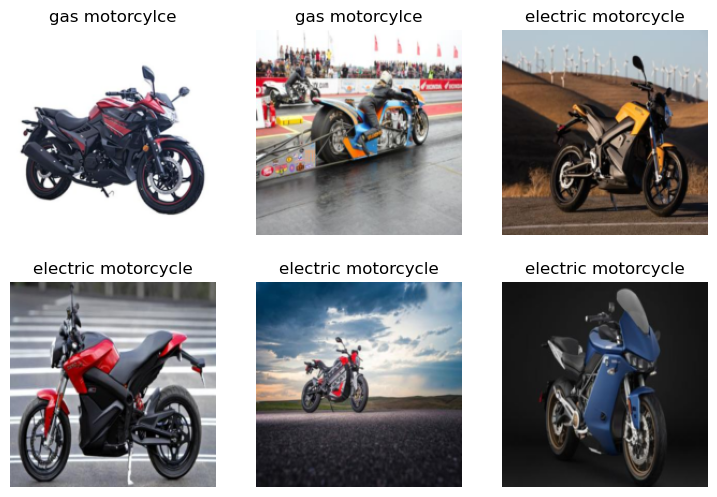

In [9]:
from fastai.vision.all import DataBlock, ImageBlock, CategoryBlock, RandomSplitter, parent_label, Resize

dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=[Resize(192, method='squish')]
).dataloaders(path, bs=32)

dls.show_batch(max_n=6)

Here what each of the `DataBlock` parameters means:

    blocks=(ImageBlock, CategoryBlock),

The inputs to our model are images, and the outputs are categories (in this case, "bird" or "forest").

    get_items=get_image_files, 

To find all the inputs to our model, run the `get_image_files` function (which returns a list of all image files in a path).

    splitter=RandomSplitter(valid_pct=0.2, seed=42),

Split the data into training and validation sets randomly, using 20% of the data for the validation set.

    get_y=parent_label,

The labels (`y` values) is the name of the `parent` of each file (i.e. the name of the folder they're in, which will be *bird* or *forest*).

    item_tfms=[Resize(192, method='squish')]

Before training, resize each image to 192x192 pixels by "squishing" it (as opposed to cropping it).

Now we're ready to train our model. The fastest widely used computer vision model is `resnet18`. You can train this in a few minutes, even on a CPU! (On a GPU, it generally takes under 10 seconds...)

`fastai` comes with a helpful `fine_tune()` method which automatically uses best practices for fine tuning a pre-trained model, so we'll use that.

In [10]:
from fastai.vision.all import vision_learner, resnet18, error_rate
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(3)

epoch,train_loss,valid_loss,error_rate,time
0,1.356554,1.173938,0.393939,00:06


epoch,train_loss,valid_loss,error_rate,time
0,0.699075,0.856610,0.393939,00:01
1,0.505649,1.113040,0.363636,00:00
2,0.390718,1.121747,0.363636,00:00


Generally when I run this I see 100% accuracy on the validation set (although it might vary a bit from run to run).

"Fine-tuning" a model means that we're starting with a model someone else has trained using some other dataset (called the *pretrained model*), and adjusting the weights a little bit so that the model learns to recognise your particular dataset. In this case, the pretrained model was trained to recognise photos in *imagenet*, and widely-used computer vision dataset with images covering 1000 categories) For details on fine-tuning and why it's important, check out the [free fast.ai course](https://course.fast.ai/).

## Step 3: Use our model (and build your own!)

Let's see what our model thinks about that bird we downloaded at the start:

In [14]:
from fastai.vision.all import PILImage

is_electric,_,probs = learn.predict(PILImage.create('electric_motorcycle.jpg'))
print(f"This is a: {is_electric}.")
print(f"Probability it's electric: {probs[0]:.4f}")

This is a: electric motorcycle.
Probability it's electric: 0.9964


Good job, resnet18. :)

So, as you see, in the space of a few years, creating computer vision classification models has gone from "so hard it's a joke" to "trivially easy and free"!

It's not just in computer vision. Thanks to deep learning, computers can now do many things which seemed impossible just a few years ago, including [creating amazing artworks](https://openai.com/dall-e-2/), and [explaining jokes](https://www.datanami.com/2022/04/22/googles-massive-new-language-model-can-explain-jokes/). It's moving so fast that even experts in the field have trouble predicting how it's going to impact society in the coming years.

One thing is clear -- it's important that we all do our best to understand this technology, because otherwise we'll get left behind!

Now it's your turn. Click "Copy & Edit" and try creating your own image classifier using your own image searches!

If you enjoyed this, please consider clicking the "upvote" button in the top-right -- it's very encouraging to us notebook authors to know when people appreciate our work.

# Conclusion

I simply modified this so that it tries to see if a motorcycle is electric or gas powered

The error rate was significantly higher than when trying to identify if a picture was a bird or not (obviously because these are more similar things)

If I were to try and improve this I think I'd do the following things:
- Clean the data to see if there are some issues with labeling
- Try and get more data to see if that starts to reduce the error
- This might not make sense, but my intuition tells me to see if there is a way to help, for example you could perhaps have it try to segment the bikes before deciding and that would highlight key differences (for example no electric motorcycle has an exhaust pipe)
- It's also totally possible that this can only get so good, because how different really are they?